In [6]:
import json
import random
from collections import namedtuple

import pandas as pd
import numpy as np
import scipy.stats as ss

import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(42)

In [7]:
data = pd.read_json("/Users/n.anokhin/Desktop/input.json", lines=True)
data["rnd"] = np.random.random(len(data))

data.head(20)

,message,timestamp,user,track,time,latency,recommendation,experiments,rnd
0,next,2023-02-28 14:49:47.487,2992,5776,1.00,0.000517,8433.0,{'AA': 'T1'},0.374540
1,next,2023-02-28 14:49:47.489,5146,6022,1.00,0.000409,41940.0,{'AA': 'T1'},0.950714
2,next,2023-02-28 14:49:47.490,6892,10163,1.00,0.000526,40880.0,{'AA': 'T1'},0.731994
3,next,2023-02-28 14:49:47.494,2992,8433,0.00,0.000475,170.0,{'AA': 'T1'},0.598658
4,next,2023-02-28 14:49:47.496,5146,41940,0.02,0.000681,9327.0,{'AA': 'T1'},0.156019
5,next,2023-02-28 14:49:47.498,6892,40880,0.00,0.000578,35202.0,{'AA': 'T1'},0.155995
6,next,2023-02-28 14:49:47.501,2992,170,0.00,0.000561,10774.0,{'AA': 'T1'},0.058084
7,next,2023-02-28 14:49:47.503,5146,9327,0.04,0.000594,13328.0,{'AA': 'T1'},0.866176
8,next,2023-02-28 14:49:47.505,6892,35202,0.00,0.000586,34800.0,{'AA': 'T1'},0.601115
9,next,2023-02-28 14:49:47.508,2992,10774,0.66,0.000590,23657.0,{'AA': 'T1'},0.708073


## Compute track popularity

In [10]:
track_popularity = (
    data[data["rnd"] > 0.5]
    .groupby("track")["time"]
    .sum()
    .to_frame()
    .sort_values("time", ascending=False)
    .reset_index()
)

track_popularity.head()

,track,time
0,246,28.05
1,171,24.00
2,170,23.09
3,177,22.16
4,2254,21.00


In [11]:
len(track_popularity)

37175

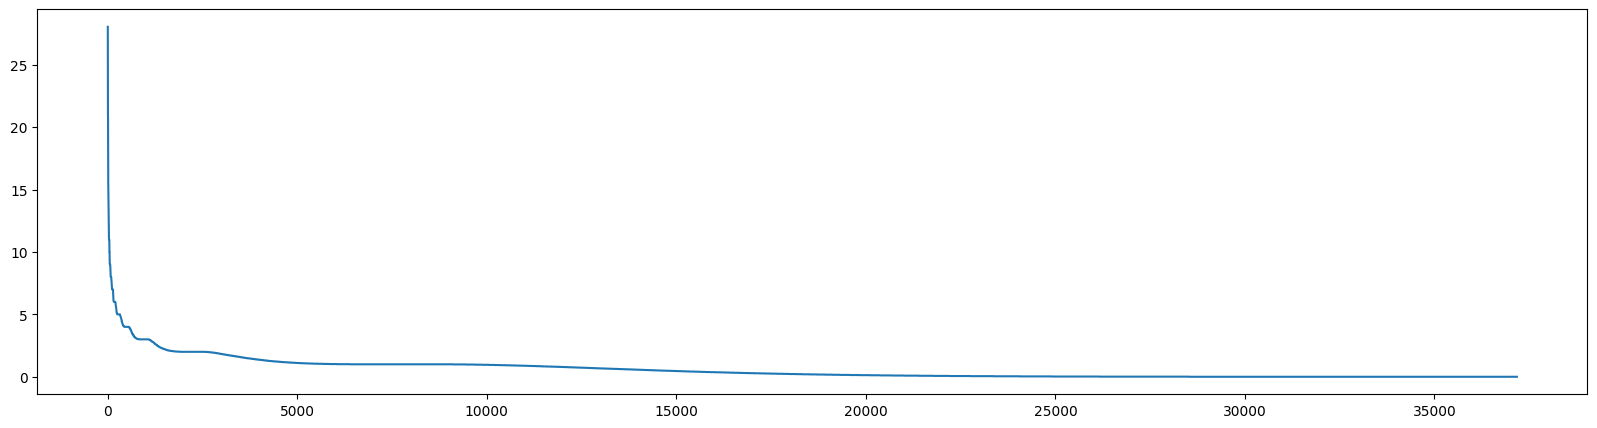

In [14]:
fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(track_popularity.index.values, track_popularity["time"].values)

# ax.set_xscale("log")
# ax.set_yscale("log")

pass

## Compute offline metrics

In [15]:
# recommendations - список рекомендованных track id от лучшего к худшему
# track           - id трека, который выбрал пользователь
# k               - k в precision@K


def precision_at(recommendations, track, k):
    return 1.0 / k * int(track in recommendations[:k])


    
def shuffled_precision_at(recommendations, track, k):
    shuffled = list(recommendations)
    random.shuffle(shuffled)
    return precision_at(shuffled, track, k)

In [16]:
tracks = track_popularity["track"].tolist()

t_p_10 = lambda track: precision_at(tracks, track, 10)
st_10_p_10 = lambda track: shuffled_precision_at(tracks[:10], track, 10)
st_100_p_10 = lambda track: shuffled_precision_at(tracks[:100], track, 10)
st_1000_p_10 = lambda track: shuffled_precision_at(tracks[:1000], track, 10)


metrics = data[(data["rnd"] <= 0.5) & (data["time"] >= 0.75)].copy()

metrics["top10_PrecAt10"] = metrics["track"].map(t_p_10)
metrics["shuffledTop10_PrecAt10"] = metrics["track"].map(st_10_p_10)
metrics["shuffledTop100_PrecAt10"] = metrics["track"].map(st_100_p_10)
metrics["shuffledTop1000_PrecAt10"] = metrics["track"].map(st_1000_p_10)

metrics[["top10_PrecAt10", "shuffledTop10_PrecAt10", "shuffledTop100_PrecAt10", "shuffledTop1000_PrecAt10"]].describe()

,top10_PrecAt10,shuffledTop10_PrecAt10,shuffledTop100_PrecAt10,shuffledTop1000_PrecAt10
count,17727.000000,17727.000000,17727.000000,17727.000000
mean,0.001241,0.001241,0.000496,0.000164
std,0.011071,0.011071,0.007028,0.004041
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,0.100000,0.100000,0.100000,0.100000


In [19]:
def mrr(recommendations, track):
    return 1.0 / (1 + recommendations.index(track)) if track in recommendations else 0.0

    
def shuffled_mrr(recommendations, track):
    shuffled = list(recommendations)
    random.shuffle(shuffled)
    return mrr(shuffled, track)

In [20]:
tracks = track_popularity["track"].tolist()

t_mrr = lambda track: mrr(tracks, track)
st_10_mrr = lambda track: shuffled_mrr(tracks[:10], track)
st_100_mrr = lambda track: shuffled_mrr(tracks[:100], track)
st_1000_mrr = lambda track: shuffled_mrr(tracks[:1000], track)

metrics = data[(data["rnd"] <= 0.5) & (data["time"] >= 0.75)].copy()

metrics["top10_mrr"] = metrics["track"].map(t_mrr)
metrics["shuffledTop10_mrr"] = metrics["track"].map(st_10_mrr)
metrics["shuffledTop100_mrr"] = metrics["track"].map(st_100_mrr)
metrics["shuffledTop1000_mrr"] = metrics["track"].map(st_1000_mrr)

metrics[["top10_mrr", "shuffledTop10_mrr", "shuffledTop100_mrr", "shuffledTop1000_mrr"]].describe()

,top10_mrr,shuffledTop10_mrr,shuffledTop100_mrr,shuffledTop1000_mrr
count,17727.000000,17727.000000,17727.000000,17727.000000
mean,0.005945,0.003577,0.002487,0.001217
std,0.050297,0.042477,0.026625,0.010675
min,0.000000,0.000000,0.000000,0.000000
25%,0.000033,0.000000,0.000000,0.000000
50%,0.000090,0.000000,0.000000,0.000000
75%,0.000508,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,0.500000


## Export data for prod

In [21]:
with open("/Users/n.anokhin/Desktop/top_tracks.json", "w") as top_tracks_file:
    json.dump(track_popularity["track"].tolist(), top_tracks_file)